# Neural Transfer Using PyTorch
https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

The algorithm takes three images, an input image, a content-image, and a style-image, and changes the input to resemble the content of the content-image and the artistic style of the style-image.

The principle is simple: we define two distances, one for the content (DC) and one for the style (DS). DC measures how different the content is between two images while DS measures how different the style is between two images. Then, we take a third image, the input, and transform it to minimize both its content-distance with the content-image and its style-distance with the style-image.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

import os

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Load images
Now we will import the style and content images. The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1. The images also need to be resized to have the same dimensions. An important detail to note is that neural networks from the torch library are trained with tensor values ranging from 0 to 1. If you try to feed the networks with 0 to 255 tensor images, then the activated feature maps will be unable sense the intended content and style. However, pre-trained networks from the Caffe library are trained with 0 to 255 tensor images.

In [2]:
data_base_dir = r'/data/neural_style_transfer'
content_img_filename = os.path.join(data_base_dir, 'content_images', 'dancing.jpg')
style_img_filename = os.path.join(data_base_dir, 'style_images', 'picasso.jpg')

# desired size of the output image
imsize = 512

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader(style_img_filename)
content_img = image_loader(content_img_filename)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"


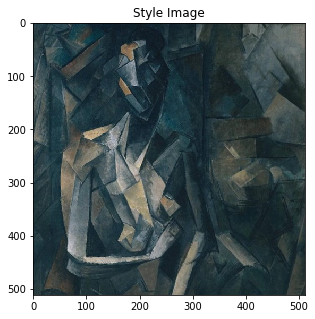

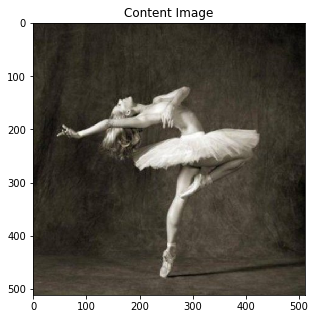

In [3]:
unloader = transforms.ToPILImage()  # reconvert into PIL image


def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure(figsize=(5,5))
imshow(style_img, title='Style Image')

plt.figure(figsize=(5,5))
imshow(content_img, title='Content Image')


### Loss function
#### Content loss
MSE between the two sets of feature maps.

Define a forward method that computes the content loss and then returns the layer’s input. The computed loss is saved as a parameter of the module.

NB: Although this module is named ContentLoss, it is not a true PyTorch Loss function. If you want to define your content loss as a PyTorch Loss function, you have to create a PyTorch autograd function to recompute/implement the gradient manually in the backward method.

In [4]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


#### Style loss


In [5]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

### Import model
PyTorch’s implementation of VGG is a module divided into two child Sequential modules: features (containing convolution and pooling layers), and classifier (containing fully connected layers). We will use the features module because we need the output of the individual convolution layers to measure content and style loss. Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using `.eval()`.

In [6]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

A `Sequential` module contains an ordered list of child modules. For instance, `vgg19.features` contains a sequence (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) aligned in the right order of depth. We need to add our content loss and style loss layers immediately after the convolution layer they are detecting. To do this we must create a new `Sequential` module that has content loss and style loss modules correctly inserted.

In [7]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

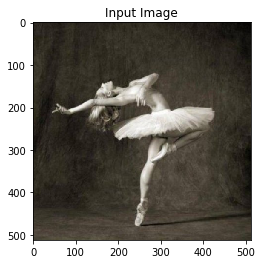

In [8]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

### Gradient descent
Unlike training a network, we want to train the input image in order to minimise the content/style losses. We will create a PyTorch L-BFGS optimizer optim.LBFGS and pass our image to it as the tensor to optimize.

In [10]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

We must define a function that performs the neural transfer. For each iteration of the networks, it is fed an updated input and computes new losses. We will run the backward methods of each loss module to dynamicaly compute their gradients. The optimizer requires a “closure” function, which reevaluates the modul and returns the loss.

We still have one final constraint to address. The network may try to optimize the input with values that exceed the 0 to 1 tensor range for the image. We can address this by correcting the input values to be between 0 to 1 each time the network is run.

In [11]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [12]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 4.207877 Content Loss: 4.259570

run [100]:
Style Loss : 1.124025 Content Loss: 3.015111

run [150]:
Style Loss : 0.710134 Content Loss: 2.654750

run [200]:
Style Loss : 0.477972 Content Loss: 2.499090

run [250]:
Style Loss : 0.345483 Content Loss: 2.413306

run [300]:
Style Loss : 0.263172 Content Loss: 2.356956



In [13]:

print(output.shape)
print('test')
# sphinx_gallery_thumbnail_number = 4


torch.Size([1, 3, 512, 512])
test


In [ ]:
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

def imprep(tensor):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    return image

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 139.008347 Content Loss: 8.785384

run [100]:
Style Loss : 40.791237 Content Loss: 8.925724

run [150]:
Style Loss : 23.347248 Content Loss: 7.568022

run [200]:
Style Loss : 16.037636 Content Loss: 6.638961

run [250]:
Style Loss : 8.457614 Content Loss: 6.019320

run [300]:
Style Loss : 5.193153 Content Loss: 5.433668

run [350]:
Style Loss : 2.782282 Content Loss: 5.008467

run [400]:
Style Loss : 1.391146 Content Loss: 4.750208

run [450]:
Style Loss : 0.785951 Content Loss: 4.464661

run [500]:
Style Loss : 0.553649 Content Loss: 4.236442

run [550]:
Style Loss : 0.454329 Content Loss: 4.071167

run [600]:
Style Loss : 0.398973 Content Loss: 3.954003



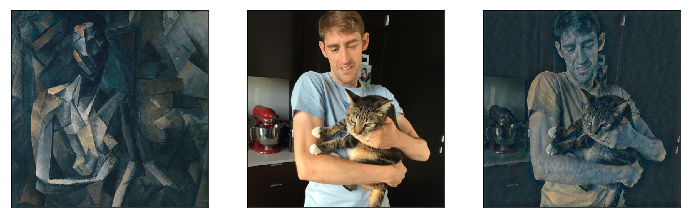

In [53]:
data_base_dir = r'/data/neural_style_transfer'
content_str = 'gabs_cat_sq.jpg'
style_str = 'picasso.jpg'
content_img_filename = os.path.join(data_base_dir, 'content_images', content_str)
style_img_filename = os.path.join(data_base_dir, 'style_images', style_str)

# desired size of the output image
imsize = 512

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


style_img = image_loader(style_img_filename)
content_img = image_loader(content_img_filename)
input_img = content_img.clone()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, style_weight=5e6, 
                           num_steps=600) #default style_weight=1000000


fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 4))
axes[0].imshow(imprep(style_img))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].imshow(imprep(content_img))
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[2].imshow(imprep(output))
axes[2].set_xticks([])
axes[2].set_yticks([])

output_img = imprep(output)
output_str = "c_%s_s_%s_5e6.png" % (content_str.replace('.','-'), style_str.replace('.','-'))
plt.imsave(os.path.join(data_base_dir, 'output', output_str), output_img)